# Machine Learning Module 3 Sprint 4 - Home Credit Group

Banking the unbanked - one of the hardest tasks in the financial world to this day. Providing credible, risk-balanced financial services and products to customers with little or no credit history would be laughed out of most financial institutions. But in the age of data we can try and leverage the machine learning models and historical data to make risk calculated decisions and enable fresh customers to use financial products in a sustainable way.

The aim of the project is to accurately predicts new credit application default risk using a variety of data sources.

To achieve the aim several objectives are set:

- Perform exploratory data analysis 
- Engineer features from all available current and historical data
- Perform feature selection 
- Create a binary classification model for default risk prediction
- Deploy generated models on GCP
- Tune and evaluate the models to a business specific problem


This notebook is dedicated for EDA and hypothesis testing for the project

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys, os

path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "src"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils
import plots

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

In [5]:
RANDOM_SEED = 42

Everything set, lets import the table. From the data description we know there is a default '365243' value present for missing values in some of the columns, we will address that right on the data import.

In [6]:
df = pd.read_csv("..\data\\application_train.csv").replace({365243: np.nan})
df = utils.reduce_df_memory(df)

## EDA

We will start EDA with the main table in the dataset "Application_train", this table has the main information provided when applying for the loan at "Home Credit", particular table also has target column included which we will utilize while performing hypothesis testing.

Exploratory data analysis will focus on understanding the customers of HomeCredit, technical information on loans themselves and give insight in which features might be most useful for the machine learning models. 

In [7]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003.0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float32(67), int16(2), int8(37)
memory usage: 95.3 MB


In [9]:
print(f"Application has {df.shape[0]} observations with {df.shape[1]} features")

Application has 307511 observations with 122 features


In [10]:
utils.data_type_count(df)

Data Types and Feature Counts in DataFrame:
int8: 37 features
int16: 2 features
float32: 67 features
category: 16 features


We have sufficiently big dataset and most of the features are numerical, with only 16 categorical features. By looking at the first few rows of the dataset we saw that quite a few of the numerical features are most likely boolean features indicating presence of certain conditions in the application.

We will focus on some categorical features and continuous numerical features to start building our understanding of the dataset and getting insights to which features could potentially be beneficial in our classification task.

#### Data cleaning

We can clean up the gender column a bit by imputing the mode value for the missing rows.

In [11]:
df["CODE_GENDER"].value_counts(normalize=True)

CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: proportion, dtype: float64

In [12]:
df["CODE_GENDER"] = df["CODE_GENDER"].replace("XNA", df["CODE_GENDER"].mode()[0])

For interpretability in exploration lets change time values from days to year in few of the features

In [13]:
df["EMP_LENGTH"] = round(abs(df["DAYS_EMPLOYED"]) / 365)
df["AGE"] = round(abs(df["DAYS_BIRTH"]) / 365)

Also checking the largest values in the AMT_INCOME_TOTAL column shows a possible outlier with an extremely high income value, we'll take care of that by dropping it out

In [14]:
df["AMT_INCOME_TOTAL"].nlargest(5)

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
Name: AMT_INCOME_TOTAL, dtype: float32

In [15]:
df = df.drop(df["AMT_INCOME_TOTAL"].idxmax())

#### Missing values

Full data is good data, lets see if there are any features with more than 50% of the values missing.

In [16]:
missing_df = utils.missing_percentage(df)
missing_df[missing_df["Percent"] > 50]

,Total,Percent
COMMONAREA_MODE,214864,69.872199
COMMONAREA_AVG,214864,69.872199
COMMONAREA_MEDI,214864,69.872199
NONLIVINGAPARTMENTS_MODE,213513,69.432864
NONLIVINGAPARTMENTS_AVG,213513,69.432864
NONLIVINGAPARTMENTS_MEDI,213513,69.432864
FONDKAPREMONT_MODE,210294,68.386069
LIVINGAPARTMENTS_AVG,210198,68.354850
LIVINGAPARTMENTS_MEDI,210198,68.354850
LIVINGAPARTMENTS_MODE,210198,68.354850


Quite a few features are missing more than half of the values, investigating the column names it seems most of the features are housing related, thus it might be natural that for customers not owning properties the information would be missing.

We will not try and fill any missing values at the moment and deal with this once we start modelling and evaluate the performance of the baseline model.

#### Feature cardinality

We will investigate how the categorical features look, all categorical features with more categories than 5 will be displayed.

In [17]:
utils.check_categorical_cardinality(df, threshold=5)

,Feature,Cardinality
0,NAME_TYPE_SUITE,8
1,NAME_INCOME_TYPE,8
2,NAME_EDUCATION_TYPE,5
3,NAME_FAMILY_STATUS,6
4,NAME_HOUSING_TYPE,6
5,OCCUPATION_TYPE,19
6,WEEKDAY_APPR_PROCESS_START,7
7,ORGANIZATION_TYPE,58
8,FONDKAPREMONT_MODE,5
9,WALLSMATERIAL_MODE,8


Seems there are only two features with high cardinality describing occupation of customer and organization type.

### Home Credit customers

Lets start with addressing the elephant in the room - target feature inbalance

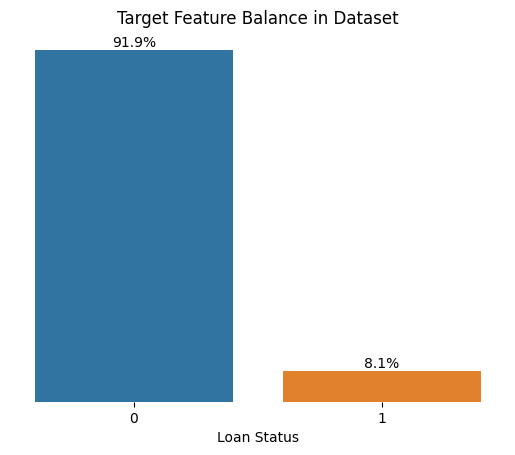

In [18]:
ax = plots.feature_balance(df, "TARGET")

ax.set_title("Target Feature Balance in Dataset")
ax.set_xlabel("Loan Status");

So the binary target feature is quite inbalanced with only 8% of the target feature being positive. Great for business as there are few loans defaulting, not so great for our prospects of building an accurate classifier.

#### Loan distribution by gender

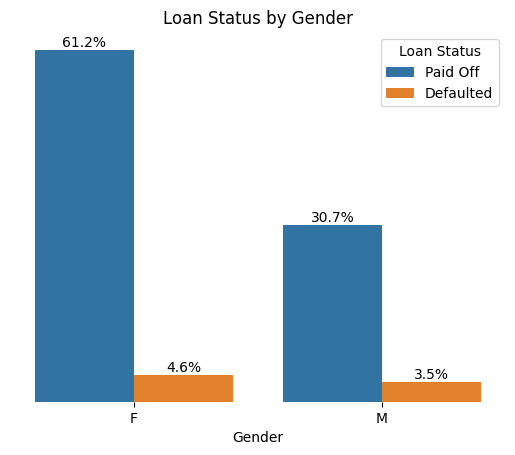

In [19]:
ax = plots.feature_balance(df, "CODE_GENDER", "TARGET")
ax.set_title("Loan Status by Gender")
ax.set_xlabel("Gender")

legend_labels = ["Paid Off", "Defaulted"]
ax.legend(title="Loan Status", labels=legend_labels);

Female clients account for higher number of loan applications in general. The default ratios for gender do not show obvious signs that there is higher percentage of defaults for specific gender.

#### Family status of customers

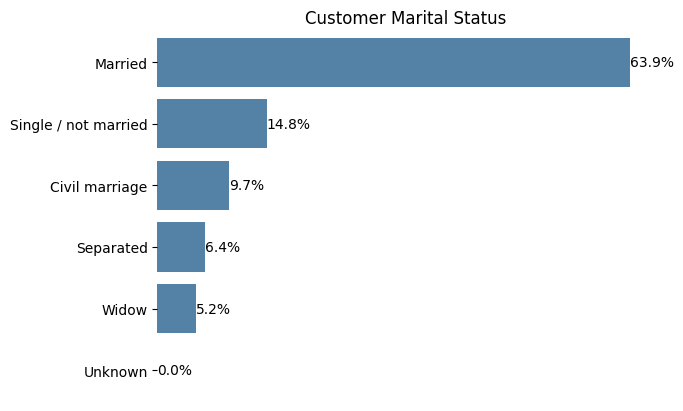

In [20]:
ax = plots.large_feature_balance(
    df, "NAME_FAMILY_STATUS", df["NAME_FAMILY_STATUS"].value_counts().index
)

ax.set_title("Customer Marital Status");

#### Eductation level of customer

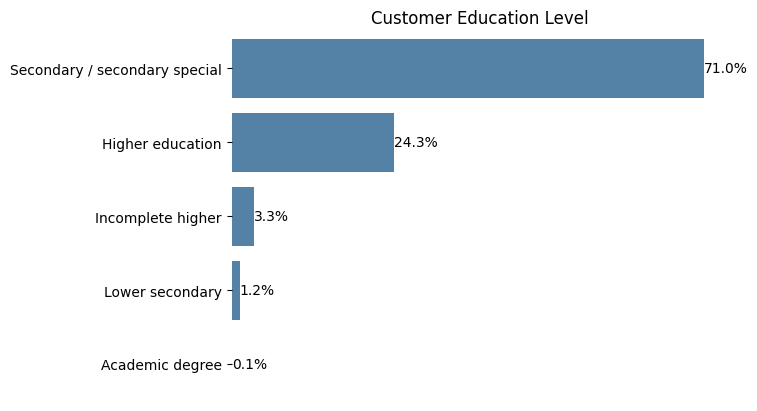

In [21]:
ax = plots.large_feature_balance(
    df, "NAME_EDUCATION_TYPE", df["NAME_EDUCATION_TYPE"].value_counts().index
)
ax.set_title("Customer Education Level");

#### Housing type

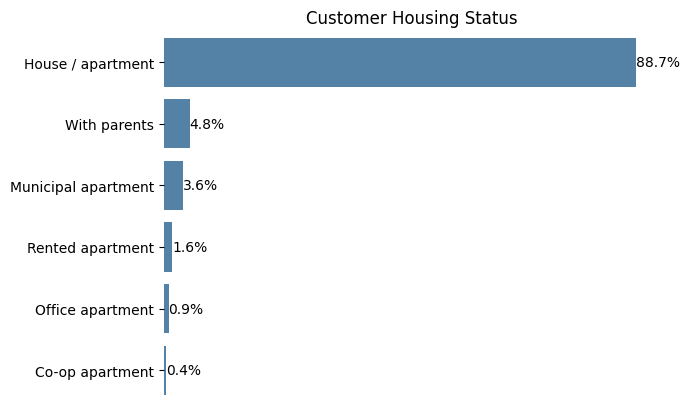

In [22]:
ax = plots.large_feature_balance(
    df, "NAME_HOUSING_TYPE", order=df["NAME_HOUSING_TYPE"].value_counts().index
)

ax.set_title("Customer Housing Status");

#### Customer eployment type/status

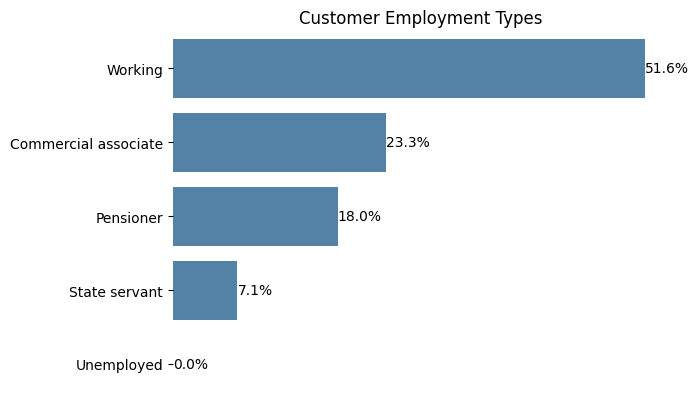

In [23]:
ax = plots.large_feature_balance(
    df,
    "NAME_INCOME_TYPE",
    order=df["NAME_INCOME_TYPE"].value_counts().nlargest(5).index,
)
ax.set_title("Customer Employment Types");

#### Customer occupation type

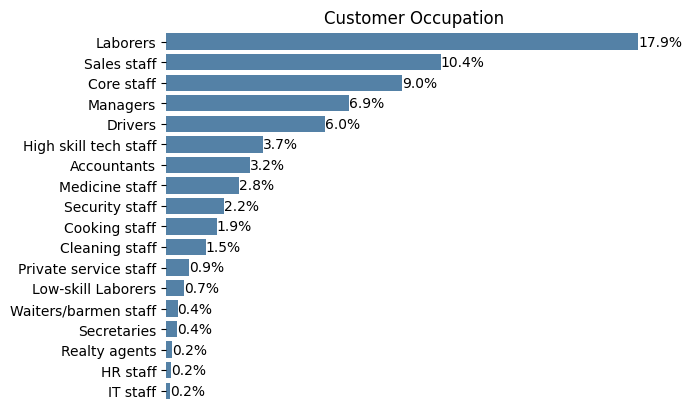

In [24]:
ax = plots.large_feature_balance(
    df, "OCCUPATION_TYPE", order=df["OCCUPATION_TYPE"].value_counts().index
)
ax.set_title("Customer Occupation");

#### Customer employer organization type

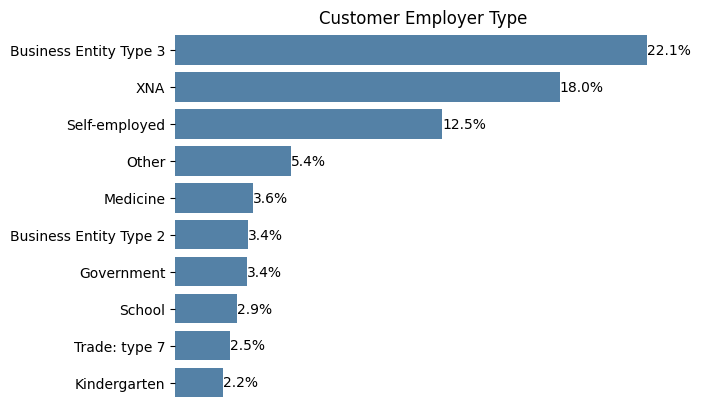

In [25]:
ax = plots.large_feature_balance(
    df,
    "ORGANIZATION_TYPE",
    order=df["ORGANIZATION_TYPE"].value_counts().nlargest(10).index,
)
ax.set_title("Customer Employer Type");

#### Customer numerical features

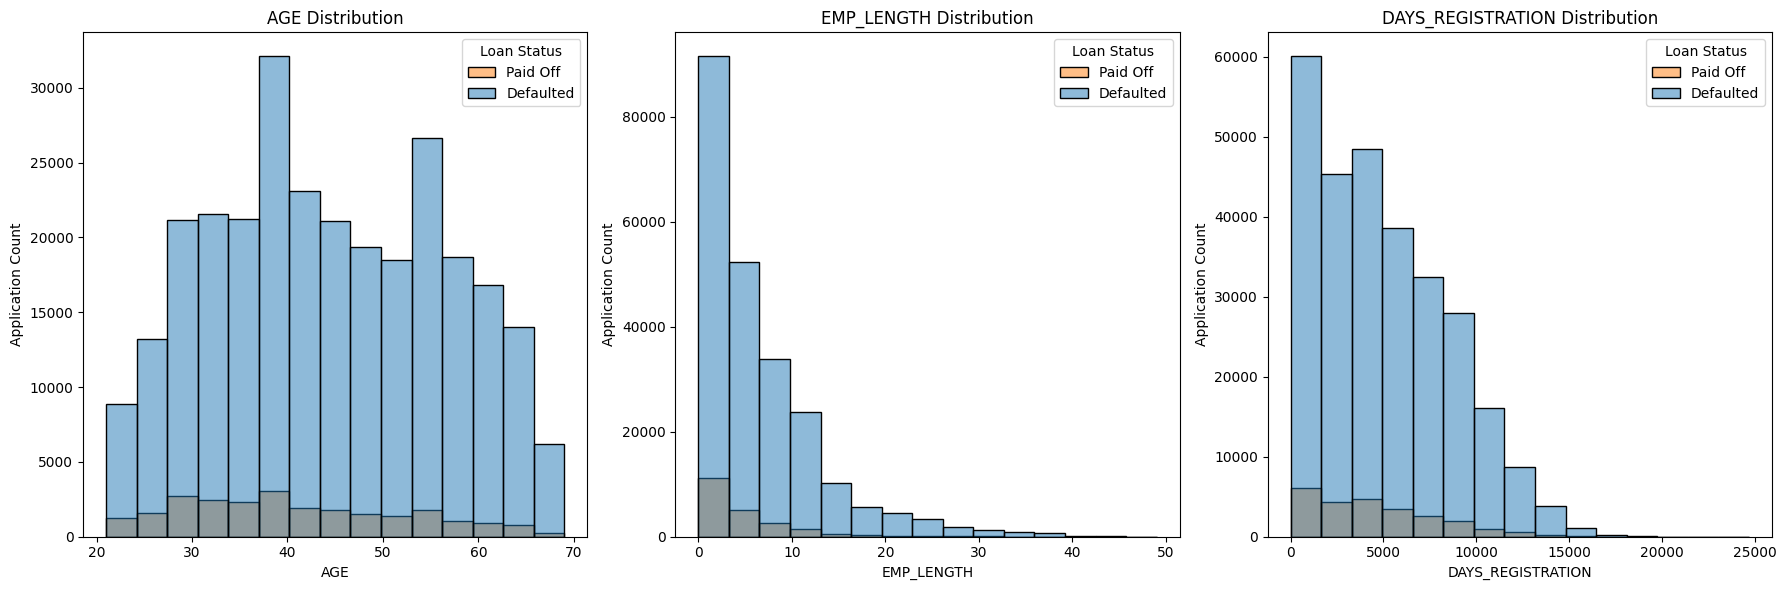

In [26]:
plots.num_feature_histogram(df, ["AGE", "EMP_LENGTH", "DAYS_REGISTRATION"])

In [27]:
print(f"Average age of customers {df['AGE'].mean():.1f}")
print(f"Average employment length of customers in years {df['EMP_LENGTH'].mean():.2f}")
print(
    f"Average number of days customers were registered before loan application {abs(df['DAYS_REGISTRATION'].mean()):.0f}"
)

Average age of customers 43.9
Average employment length of customers in years 6.53
Average number of days customers were registered before loan application 4986


### HomeCredit Loans

We can start investigating the loans themselves. Starting off with loan contract types.

#### Loan conatract types

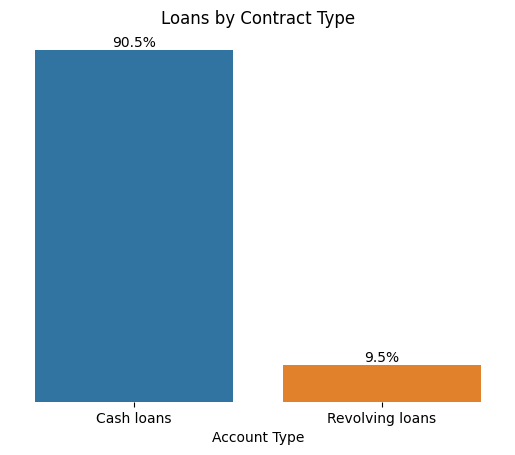

In [28]:
ax = plots.feature_balance(df, "NAME_CONTRACT_TYPE")
ax.set_title("Loans by Contract Type")
ax.set_xlabel("Account Type");

Looks like most of the loans issued by HomeCredit are cash loans with standard pre-determined installments and fixed term. Close to tenth of all loans are actually revolving loans, offering customers better flexibility.

#### Loan properties

Overview for numerical features related to loans in dataset look like

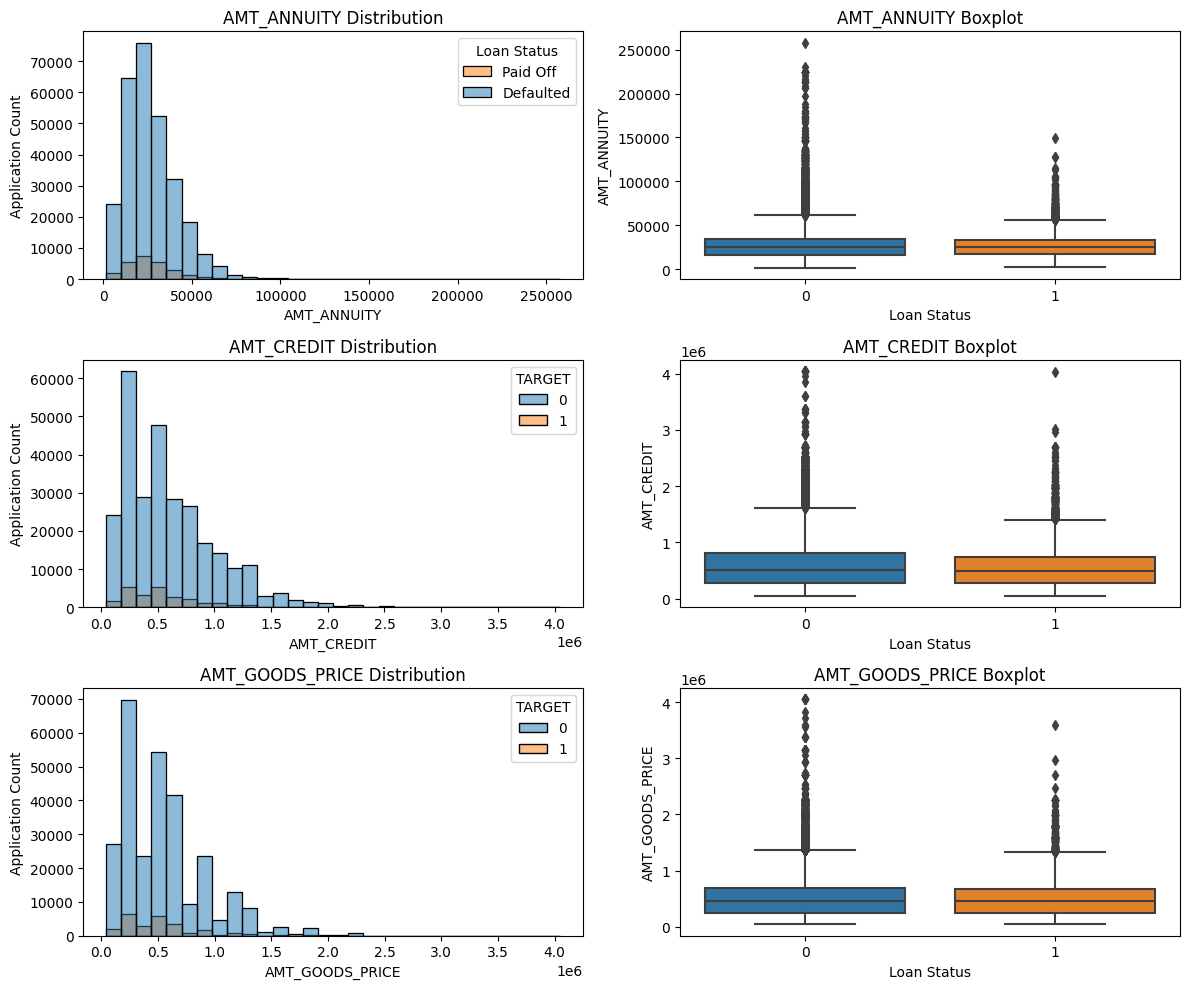

In [29]:
ax = plots.num_feature_combined(df, ["AMT_ANNUITY", "AMT_CREDIT", "AMT_GOODS_PRICE"])

In [30]:
print(f"Average value of loan annuity {df['AMT_ANNUITY'].mean():.2f}")
print(f"Average credit amount funded {df['AMT_CREDIT'].mean():.2f}")
print(f"Average price of goods funded by loans {df['AMT_GOODS_PRICE'].mean():.2f}")

Average value of loan annuity 27108.58
Average credit amount funded 599025.94
Average price of goods funded by loans 538396.44


We can observe the numerical amount features: Annuity, Credit, Goods Price all having similar distribution with Annuity being more normally distributed and two other features having a right skew. There are no observable difference in distributions with regards to the target feature.

Box-plots show similar average (median) values for each feature with regards to the target feature. Quite a few values recorded over the top whiskers as potential outliers. This is difficult to judge as the loan amounts are a mix of 4 different currencies which cannot be identified individually, thus the scale is not uniform. As our focus is on features that are clearly separated by target feature, we can move on and look for stronger information gain with other features.

#### Customer annual income

Finally we can plot the distribution of customer annual income and see if there are any interesting patters or separation with regards to target feature. Since the currencies are mixed and some values are quite extreme we will plot the values on logarithmic scale.

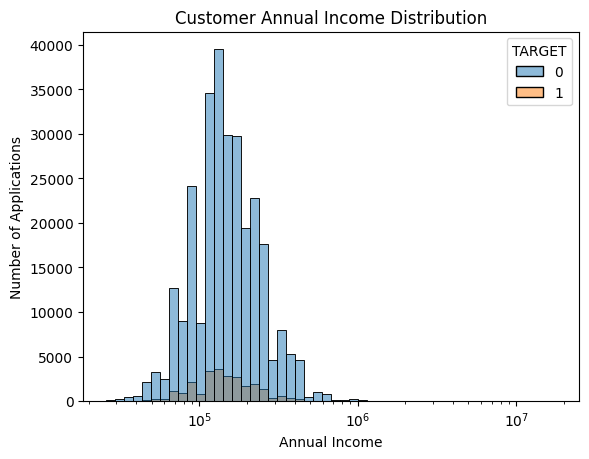

In [31]:
ax = sns.histplot(df, x=df["AMT_INCOME_TOTAL"], hue="TARGET", log_scale=True, bins=50)
ax.set_title("Customer Annual Income Distribution")
ax.set_ylabel("Number of Applications")
ax.set_xlabel("Annual Income");

In [32]:
print(f"Average annual income of customers {df['AMT_INCOME_TOTAL'].mean():.2f}")

Average annual income of customers 168418.00


Normally distributed on a log scale, the annual income of customers feature does not suggest any clear separation for paid off and defaulted loans either.

### Domain specific features

The dataset has some encoded and already scaled values EXT_SOURCE 1/2/3. Since there is no information on how these features were generated and what they mean, we can only investigate if they can give us any signal on target feature.

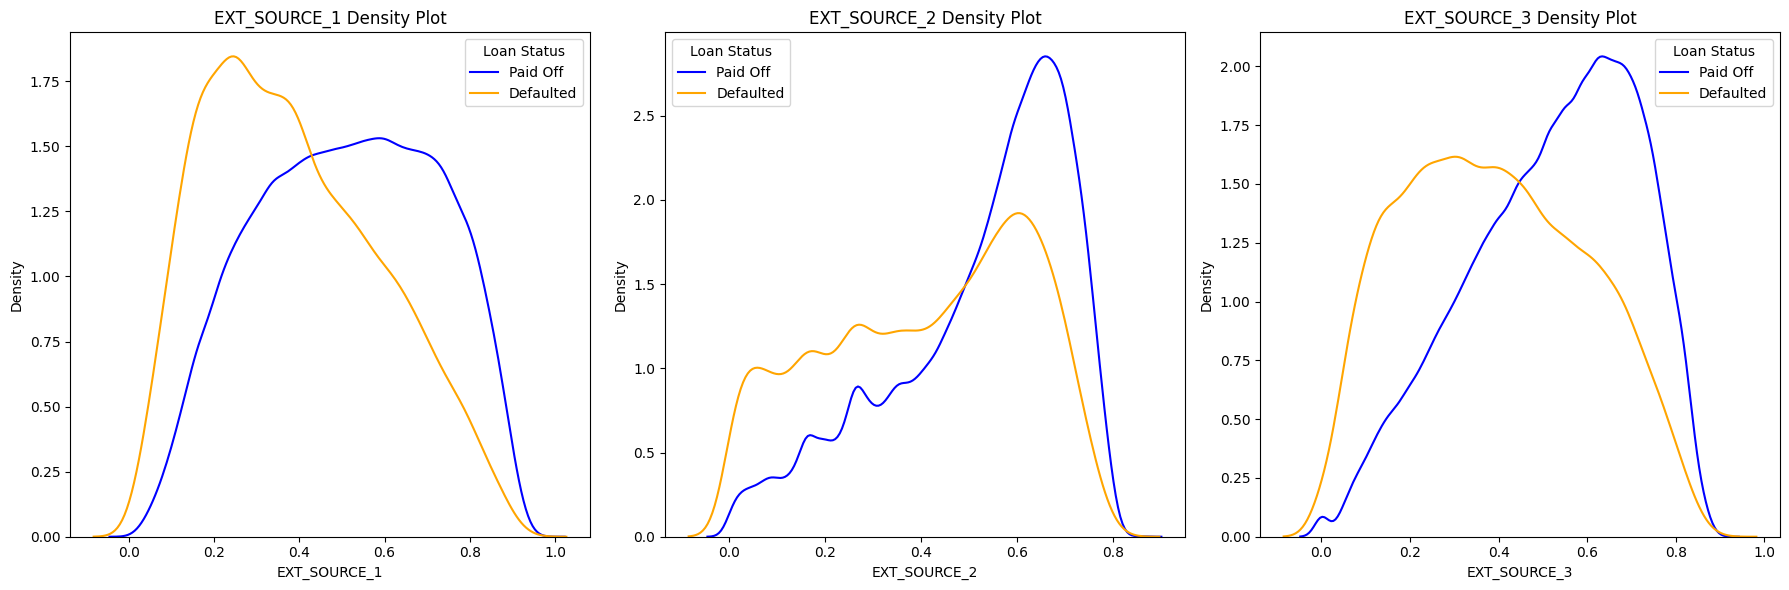

In [33]:
plots.kde_plots(df, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"])

We can see some separation between the target feature categories and EXT_SOURCE features. Especially EXT_SOURCE1 and EXT_SOURCE3 suggest some separability between the classes. These features might prove very useful in the classification task.

## Hypothesis testing

To understand the dataset better a series of hypotheses will be tested using standard statistical inference tools. The aim is to determine if there is any significance in categorical and numerical features with regards to the target variable. 

Tests are split into categorical and numerical parts, for each part the following assumptions are met:

- All observations are independent
- Chi2 test contingency tables are mutually exclusive and at least 80% of cells have more than 5 expected values
- Numerical features follow continuous or ordinal scale
- Numerical t-Test samples are large enough to assume data normality 

The hypothesis is the same for both numerical and categorical feature groups:

- Ho- Feature has no significance in loan status outcome (paid-off/defaulted)

- Alternate hypothesis- Feature has significance in loan status outcome (paid-off/defaulted)

Significance level P set to 0.05

Aim of the tests is to determine which features are significant with regards to the target feature. Since the p-value represents the probability of observing a test statistic as extreme as the one calculated, assuming that the null hypothesis is true. With larger sample sizes, the standard errors of estimates tend to decrease, making it easier to detect smaller effects. In this particular case the sample sizes available are quite large and we expect most of the tests to reject null hypothesis with a small p value, but that does not mean the significance is very useful. To put the significance in perspective we will calculate "Cramer's V" and "Cohen's d" as indications for categorical feature association and power of numerical features.

#### Categorical features

In [34]:
cat_features = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "ORGANIZATION_TYPE",
]

In [35]:
utils.hypothesis_chi2_power(df, cat_features, "TARGET")

,Feature,P-Value,Null Hypothesis,Cramer's V
0,ORGANIZATION_TYPE,5.887614e-299,Reject,0.072335
1,NAME_EDUCATION_TYPE,2.676858e-219,Reject,0.057566
2,CODE_GENDER,3.602702e-202,Reject,0.054709
3,NAME_FAMILY_STATUS,7.208008e-107,Reject,0.040518
4,NAME_HOUSING_TYPE,1.054729e-88,Reject,0.036985
5,NAME_CONTRACT_TYPE,1.053520e-65,Reject,0.030873
6,FLAG_OWN_CAR,9.815650e-34,Reject,0.021831
7,FLAG_OWN_REALTY,6.581829e-04,Reject,0.006143


By the P-values observed in the categorical feature test we can reject the null hypothesis for all of the features in the table. However, looking at the Cramer's V value for association we see that by the standard scale of "Cramer's V value <0.1 = "Weak or no association" there are no features that are highly associated with the target feature even though they are all significant by the definition of chi2 test.

#### Numerical values 

In [36]:
num_features = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "AGE",
    "EMP_LENGTH",
]

In [37]:
utils.hypothesis_ttest_power(df, num_features, "TARGET")

,Feature,P-Value,Null Hypothesis,Cohen's d
0,EXT_SOURCE_3,0.000000e+00,Reject,0.679391
1,EXT_SOURCE_1,0.000000e+00,Reject,0.597118
2,EXT_SOURCE_2,0.000000e+00,Reject,0.596719
3,AGE,0.000000e+00,Reject,0.288153
4,EMP_LENGTH,0.000000e+00,Reject,0.267332
5,AMT_GOODS_PRICE,4.451267e-143,Reject,0.145637
6,AMT_CREDIT,2.752764e-82,Reject,0.111532
7,AMT_INCOME_TOTAL,2.973046e-43,Reject,0.075122
8,AMT_ANNUITY,3.871059e-16,Reject,0.047049


Same as with the categorical feature hypothesis tests all of the numerical features are significant by the definition of P-value. To estimate relative power of how significant the continuous numerical features are with regards to the target feature Cohen's d was calculated as well. By standard definition of Cohen's d effect sizes are: small (d = 0.2), medium (d = 0.5), and large (d = 0.8). The effect size interpretation depends on the subject and domain knowledge has to be applied. 

We can see that 'EXT_SOURCE" features have medium effect with almost twice the value of AGE and EMPLOYMENT LENGTH. This is a good indication that the features will be important in our machine learning models.

## Conclusions

EDA was performed on application table from the dataset, some of the main findings are:

- Default loans account for ~8% of all loans in the dataset
- 90,5% of all loans were cash loans with the remaining being revolving loans
- ~65% of all loan applications were female customers
- 63,9% of all customers were married 
- 95,3% of all customers had "Secondary/Secondary Special" or "Higher" education
- 69,3% of all customers indicated that they own real property
- Average customer age was 43,9 years with average 6,53 years of employment length


- Average annual income of customers  - 168418 in mixed currency
- Average credit funded to customers  - 599025.94 in mixed currency
- Average annuity for issued loans - 27108.58 in mixed currency

Average credit size was ~3,5 times larger than average customer income

Selection of numerical and categorical features were tested for significance with regards to the target (Loan Default) feature using hypothesis testing. Due to large sample size all of the tested features come up as significant with small P values. Additional association and power analysis was done using Cramer's V for categorical features and Cohen's d for numerical features:

None of the significant categorical features have strong associations to the target feature

Numerical features with significant power:

- EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2 - medium power
- AGE,EMPLOYMENT_LENGTH - small power.

Correlation analysis of features was not performed in the EDA part of the project as it will be performed once feature engineering is done and feature selection is started.


### Please refer to Feature Engineering notebook for next part of the project